# Example HDF5 Insights

This Jupyter Notebook should give a brief overview how to programmatically analyze the HDF5 files produced by *mycelyso*. Please note that you can always inspect these files with *mycelyso Inspector* as well, this tutorial should just give you a hint how to open these files if you might want to write your own analyses.

First, it is assumed that an `output.h5` is present in the current directory, with an analysis of the *example dataset* contained.

You can fetch the *example dataset* by running `get-dataseth.sh` or download it manually at https://zenodo.org/record/376281.

Afterwards, analyze it with:
```
> python -m mycelyso S_lividans_TK24_Complex_Medium_nd046_138.ome.tiff -t BoxDetection=1
```

Afterwards, you will have an `output.h5` in the residing in the directory.

We will be using [Pandas](https://pandas.pydata.org) to read our data, while the non-tabular data could easily be read with any other HDF5 compatible tool, the tabular data is layed out in a chunked format particular to Pandas, and as such it is easiest to open it with Pandas.

First, some general setup …

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
import pandas
pandas.options.display.max_columns = None
import numpy as np
import networkx as nx
from networkx.readwrite import GraphMLReader

from matplotlib import pyplot, ticker
pyplot.rcParams.update({
    'figure.figsize': (10, 6), 'svg.fonttype': 'none',
    'font.sans-serif': 'Arial', 'font.family': 'sans-serif',
    'image.cmap': 'gray_r', 'image.interpolation': 'none'
})

## Opening the HDF5 file
We will load the `output.h5` using `pandas.HDFStore` …

In [2]:
store = pandas.HDFStore('output.h5', 'r')
store

<class 'pandas.io.pytables.HDFStore'>
File path: output.h5
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/result_table                                                                          frame        (shape->[1,208]) 
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/result_table_collected                                                                frame        (shape->[136,27])
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/tables/_individual_track_table_aux_tables/track_table_aux_tables_000000001            frame        (shape->[22,8])  
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/tables/_individual_track_table_aux_tables/track_table_aux_tables_000000002            frame        (shape->[29,8])  
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/tables/_individual_track_tab

Now let's dive a bit into the HDF5 file.

Remember that HDF5 stands for *Hierarchical* Data Format 5 …

In [3]:
root = store.get_node('/')

print("Root:")
print(repr(root))
print()
print("/results:")
print(repr(root.results))

Root:
/ (RootGroup) ''
  children := ['results' (Group)]

/results:
/results (Group) ''
  children := ['tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff' (Group)]


The key names are dependent on the on-disk path of the analyzed file.
Assuming there is only one file analyzed with one position in the file, we pick the first …

In [4]:
for image_file in root.results:
    print(image_file)
    for position in image_file:
        print(position)
        break

/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff (Group) ''
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected (Group) ''


We can now investigate what data is available for that particular position

There is e.g., (binary) data, there are images, and there are various tabular datasets

In [5]:
print("data")
print(position.data)
for node in position.data:
    print(node)
    
print()
    
print("nodes")
print(position.images)
for node in position.images:
    print(node)
    
print()    

data
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/data (Group) ''
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/data/banner (Group) ''
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/data/graphml (Group) ''
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/data/overall_graphml (Group) ''
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/data/tunables (Group) ''
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/data/version (Group) ''

nodes
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/images (Group) ''
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/images/binary (Group) ''
/results/tmp_S_lividans_TK24_Complex_Medium_nd046_138_ome_tiff/pos_000000000_t_Collected/

## Accessing Graph and Image Data
Let's for example start with pulling out an image from the file, and displaying it …

Total count of images: 136


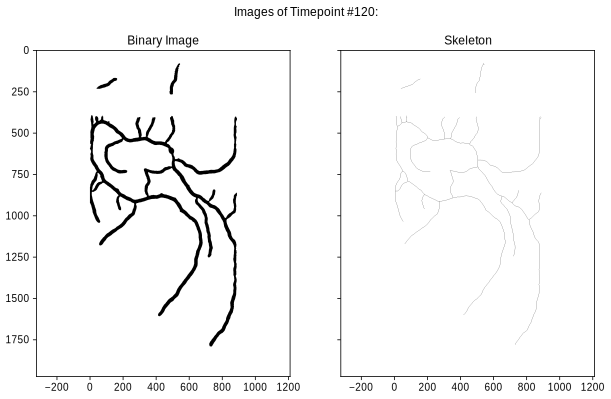

In [6]:
binary_images = list(position.images.binary)
skeleton_images = list(position.images.skeleton)

n = 120

total = len(binary_images)
assert 0 <= n < total

print("Total count of images: %d" % (total,))

fig, (ax_l, ax_r) = pyplot.subplots(1, 2, sharey=True)

fig.suptitle('Images of Timepoint #%d:' % (n,))

ax_l.imshow(binary_images[n])
ax_l.set_title('Binary Image')

ax_r.imshow(skeleton_images[n])
ax_r.set_title('Skeleton')

Let's now take a look at the graph data present for the position, display it and overlay it onto the image data …

Example node: 1: {'x': 543.0, 'y': 91.0}
Some other node: 4
The distance between the two nodes is: 192.05 px


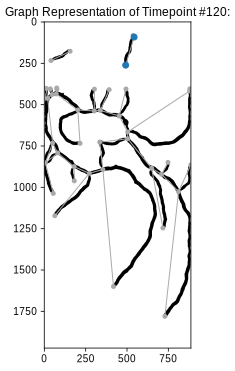

In [7]:
# The graph structure is saved in GraphML
draw_parameters = dict(node_size=25, node_color='darkgray', linewidths=0, edge_color='darkgray', with_labels=False)

#graphml_data = list([np.array(graphml).tobytes() for graphml in list(position.data.graphml)])
graphml_data = list(position.data.graphml)

graph, = GraphMLReader()(string=np.array(graphml_data[n]).tobytes())

# the following draw function needs separate positions...
# each node has its position saved as attributes:

example_node_id = list(sorted(graph.node.keys()))[1]

print("Example node: %s: %r" % (example_node_id, graph.node[example_node_id],))

other_node_id = list(sorted(graph.edge[example_node_id].keys(), reverse=True))[0]

print("Some other node: %s" % (other_node_id,))


print("The distance between the two nodes is: %.2f px" % (graph.edge[example_node_id][other_node_id]['weight']))

pyplot.title('Graph Representation of Timepoint #%d:' % (n,))

# first draw the graph,
pos = {n_id: (n['x'], n['y']) for n_id, n in graph.node.items()}
nx.draw_networkx(graph, pos=pos, **draw_parameters)

example_nodes = [graph.node[node_id] for node_id in [example_node_id, other_node_id]]

# mark on top the two choosen sample nodes
pyplot.scatter([p['x'] for p in example_nodes], [p['y'] for p in example_nodes], zorder=2)

# then show the corresponding binarized image
pyplot.imshow(binary_images[n])

## Accessing Tabular Data

In the next few cells we'll take a look at the tabular data stored in the HDF5 file.

There is for example the `result_table`, which contains compounded information about the whole position:

In [8]:
result_table = store[position.result_table._v_pathname]
result_table

,_mapping_track_table_aux_tables,banner,covered_area_linear_regression_intercept,covered_area_linear_regression_pvalue,covered_area_linear_regression_rvalue,covered_area_linear_regression_slope,covered_area_linear_regression_stderr,covered_area_logarithmic_regression_intercept,covered_area_logarithmic_regression_pvalue,covered_area_logarithmic_regression_rvalue,covered_area_logarithmic_regression_slope,covered_area_logarithmic_regression_stderr,covered_area_optimized_linear_regression_begin,covered_area_optimized_linear_regression_begin_index,covered_area_optimized_linear_regression_end,covered_area_optimized_linear_regression_end_index,covered_area_optimized_linear_regression_intercept,covered_area_optimized_linear_regression_pvalue,covered_area_optimized_linear_regression_rvalue,covered_area_optimized_linear_regression_slope,covered_area_optimized_linear_regression_stderr,covered_area_optimized_logarithmic_regression_begin,covered_area_optimized_logarithmic_regression_begin_index,covered_area_optimized_logarithmic_regression_end,covered_area_optimized_logarithmic_regression_end_index,covered_area_optimized_logarithmic_regression_intercept,covered_area_optimized_logarithmic_regression_pvalue,covered_area_optimized_logarithmic_regression_rvalue,covered_area_optimized_logarithmic_regression_slope,covered_area_optimized_logarithmic_regression_stderr,covered_ratio_linear_regression_intercept,covered_ratio_linear_regression_pvalue,covered_ratio_linear_regression_rvalue,covered_ratio_linear_regression_slope,covered_ratio_linear_regression_stderr,covered_ratio_logarithmic_regression_intercept,covered_ratio_logarithmic_regression_pvalue,covered_ratio_logarithmic_regression_rvalue,covered_ratio_logarithmic_regression_slope,covered_ratio_logarithmic_regression_stderr,covered_ratio_optimized_linear_regression_begin,covered_ratio_optimized_linear_regression_begin_index,covered_ratio_optimized_linear_regression_end,covered_ratio_optimized_linear_regression_end_index,covered_ratio_optimized_linear_regression_intercept,covered_ratio_optimized_linear_regression_pvalue,covered_ratio_optimized_linear_regression_rvalue,covered_ratio_optimized_linear_regression_slope,covered_ratio_optimized_linear_regression_stderr,covered_ratio_optimized_logarithmic_regression_begin,covered_ratio_optimized_logarithmic_regression_begin_index,covered_ratio_optimized_logarithmic_regression_end,covered_ratio_optimized_logarithmic_regression_end_index,covered_ratio_optimized_logarithmic_regression_intercept,covered_ratio_optimized_logarithmic_regression_pvalue,covered_ratio_optimized_logarithmic_regression_rvalue,covered_ratio_optimized_logarithmic_regression_slope,covered_ratio_optimized_logarithmic_regression_stderr,filename,filename_complete,graph_edge_count_linear_regression_intercept,graph_edge_count_linear_regression_pvalue,graph_edge_count_linear_regression_rvalue,graph_edge_count_linear_regression_slope,graph_edge_count_linear_regression_stderr,graph_edge_count_logarithmic_regression_intercept,graph_edge_count_logarithmic_regression_pvalue,graph_edge_count_logarithmic_regression_rvalue,graph_edge_count_logarithmic_regression_slope,graph_edge_count_logarithmic_regression_stderr,graph_edge_count_optimized_linear_regression_begin,graph_edge_count_optimized_linear_regression_begin_index,graph_edge_count_optimized_linear_regression_end,graph_edge_count_optimized_linear_regression_end_index,graph_edge_count_optimized_linear_regression_intercept,graph_edge_count_optimized_linear_regression_pvalue,graph_edge_count_optimized_linear_regression_rvalue,graph_edge_count_optimized_linear_regression_slope,graph_edge_count_optimized_linear_regression_stderr,graph_edge_count_optimized_logarithmic_regression_begin,graph_edge_count_optimized_logarithmic_regression_begin_index,graph_edge_count_optimized_logarithmic_regression_end,graph_edge_count_optimized_logarithmic_regression_end_index,graph_edge_count_optimized_logarithmic_regression_intercept,graph_edge_count_optimized_log

Then there is the `result_table_collected`, which contains collected information about every single frame of the time series of one position:

In [9]:
result_table_collected = store[position.result_table_collected._v_pathname]
result_table_collected

,area,binary,calibration,covered_area,covered_ratio,crop_b,crop_l,crop_r,crop_t,filename,graph_edge_count,graph_edge_length,graph_endpoint_count,graph_junction_count,graph_node_count,graphml,image_sha256_hash,input_height,input_width,meta_pos,meta_t,metadata,shift_x,shift_y,skeleton,timepoint,tunables_hash
0,7393.965475,0,0.065,0.000000,0.000000,1978,754,1642,4,S_lividans_TK24_Complex_Medium_nd046_138.ome.tiff,0.0,0.000000,0,0,0,0,FLHyF8lkwKef9Q9yEWsgOFzYc4qFCpKyirTRsfsR7/g=,128.245,57.655,0,0,,3.0,3.0,0,356.745246,VERSION:1:SHA256:ly9V6atfXJwdK3mHZ7jb5KlnHCRNI...
1,7393.965475,1,0.065,0.000000,0.000000,1978,754,1642,4,S_lividans_TK24_Complex_Medium_nd046_138.ome.tiff,0.0,0.000000,0,0,0,1,494VC0oqeVoCO/0IYeZnowKoultCZe+iYTW5/xRIfXQ=,128.245,57.655,0,1,,0.0,0.0,1,954.331815,VERSION:1:SHA256:ly9V6atfXJwdK3mHZ7jb5KlnHCRNI...
2,7393.965475,2,0.065,0.000000,0.000000,1978,754,1642,4,S_lividans_TK24_Complex_Medium_nd046_138.ome.tiff,0.0,0.000000,0,0,0,2,kg3NjTylgz8a9Z7wnSSmEgxZHxP0tAaj1dxCWuGaMec=,128.245,57.655,0,2,,-3.0,-2.0,2,1548.970068,VERSION:1:SHA256:ly9V6atfXJwdK3mHZ7jb5KlnHCRNI...
3,7393.965475,3,0.065,0.000000,0.000000,1978,754,1642,4,S_lividans_TK24_Complex_Medium_nd046_138.ome.tiff,0.0,0.000000,0,0,0,3,S6KmMEQmUxMdLbpBnAyTs01xKaGIBjtgP1g/Raq9zqg=,128.245,57.655,0,3,,-6.0,-4.0,3,2152.429459,VERSION:1:SHA256:ly9V6atfXJwdK3mHZ7jb5KlnHCRNI...
4,7393.965475,4,0.065,0.000000,0.000000,1978,754,1642,4,S_lividans_TK24_Complex_Medium_nd046_138.ome.tiff,0.0,0.000000,0,0,0,4,EM4yxCU5tahPntThJVNQtAus2R69jCszYck1ZHFDhX4=,128.245,57.655,0,4,,-4.0,-5.0,4,2754.315663,VERSION:1:SHA256:ly9V6atfXJwdK3mHZ7jb5KlnHCRNI...
5,7393.965475,5,0.065,11.766625,0.001591,1978,754,1642,4,S_lividans_TK24_Complex_Medium_nd046_138.ome.tiff,5.5,22.899434,5,0,5,5,c+9vT5uE1ozpUvzrkp1EQcG03GORVwOTjxjrZqRPQn4=,128.245,57.655,0,5,,-9.0,-5.0,5,3349.845006,VERSION:1:SHA256:ly9V6atfXJwdK3mHZ7jb5KlnHCRNI...
6,7393.965475,6,0.065,21.931975,0.002966,1978,754,1642,4,S_lividans_TK24_Complex_Medium_nd046_138.ome.tiff,15.5,41.708488,11,1,12,6,xvSVz5s+PLa4Sj8oHuz83v2KXW8W//20bogdtZYFYps=,128.245,57.655,0,6,,-8.0,-4.0,6,3954.256373,VERSION:1:SHA256:ly9V6atfXJwdK3mHZ7jb5KlnHCRNI...
7,7393.965475,7,0.065,18.877300,0.002553,1978,754,1642,4,S_lividans_TK24_Complex_Medium_nd046_138.ome.tiff,11.5,38.285793,9,0,9,7,LDTibVqcoMtulQHwHHQUgtHV1xUFeIk+AnZxudajBL0=,128.245,57.655,0,7,,-7.0,-6.0,7,4548.847011,VERSION:1:SHA256:ly9V6atfXJwdK3mHZ7jb5KlnHCRNI...
8,7393.965475,8,0.065,11.306100,0.001529,1978,754,1642,4,S_lividans_TK24_Complex_Medium_nd046_138.ome.tiff,9.0,21.241934,7,0,7,8,a3O6yoCLPmRkTBo/O7VFHi62Yc2lxx3w7b4BXKCskPk=,128.245,57.655,0,8,,-8.0,-5.0,8,5149.800172,VERSION:1:SHA256:ly9V6atfXJwdK3mHZ7jb5KlnHCRNI...
9,7393.965475,9,0.065,19.612450,0.002652,1978,754,1642,4,S_lividans_TK24_Complex_Medium_nd046_138.ome.tiff,19.0,37.788097,12,3,15,9,R8zOCET5fdw+UveaB1/weWXLjxRewlTgsh6JAe1cl2A=,128.245,57.655,0,9,,-9.0,-3.0,9,5747.743609,VERSION:1:SHA256:ly9V6atfXJwdK3mHZ7jb5KlnHCRNI...


The per-frame informations contain e.g. the graph length (i.e. the mycelium length), which can be plotted over time:

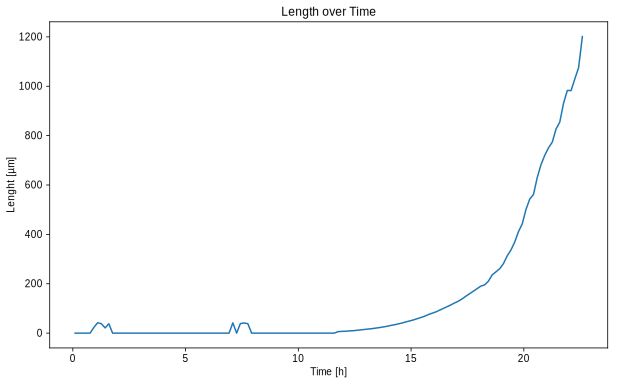

In [10]:
timepoint = result_table_collected.timepoint / (60*60)
length = result_table_collected.graph_edge_length

pyplot.title('Length over Time')

pyplot.xlabel('Time [h]')
pyplot.ylabel('Lenght [µm]')

pyplot.plot(timepoint, length)

Last but not least, we will look at mycelium level tracking data in the `track_table`.
The `track_table` is a level deeper in the HDF5 structure, next to tables with individual tracks.

In [11]:
track_table = store[list(position.tables.track_table)[0]._v_pathname]
track_table

,aux_table,count,duration,logarithmic_normalized_regression_intercept,logarithmic_normalized_regression_pvalue,logarithmic_normalized_regression_rvalue,logarithmic_normalized_regression_slope,logarithmic_normalized_regression_stderr,logarithmic_plain_regression_intercept,logarithmic_plain_regression_pvalue,logarithmic_plain_regression_rvalue,logarithmic_plain_regression_slope,logarithmic_plain_regression_stderr,maximum_distance,maximum_distance_num,minimum_distance,minimum_distance_num,normalized_regression_intercept,normalized_regression_pvalue,normalized_regression_rvalue,normalized_regression_slope,normalized_regression_stderr,optimized_logarithmic_normalized_regression_begin,optimized_logarithmic_normalized_regression_begin_index,optimized_logarithmic_normalized_regression_end,optimized_logarithmic_normalized_regression_end_index,optimized_logarithmic_normalized_regression_intercept,optimized_logarithmic_normalized_regression_pvalue,optimized_logarithmic_normalized_regression_rvalue,optimized_logarithmic_normalized_regression_slope,optimized_logarithmic_normalized_regression_stderr,optimized_logarithmic_regression_begin,optimized_logarithmic_regression_begin_index,optimized_logarithmic_regression_end,optimized_logarithmic_regression_end_index,optimized_logarithmic_regression_intercept,optimized_logarithmic_regression_pvalue,optimized_logarithmic_regression_rvalue,optimized_logarithmic_regression_slope,optimized_logarithmic_regression_stderr,optimized_normalized_regression_begin,optimized_normalized_regression_begin_index,optimized_normalized_regression_end,optimized_normalized_regression_end_index,optimized_normalized_regression_intercept,optimized_normalized_regression_pvalue,optimized_normalized_regression_rvalue,optimized_normalized_regression_slope,optimized_normalized_regression_stderr,optimized_regression_begin,optimized_regression_begin_index,optimized_regression_end,optimized_regression_end_index,optimized_regression_intercept,optimized_regression_pvalue,optimized_regression_rvalue,optimized_regression_slope,optimized_regression_stderr,plain_regression_intercept,plain_regression_pvalue,plain_regression_rvalue,plain_regression_slope,plain_regression_stderr,timepoint_begin,timepoint_center,timepoint_end
0,0,22,12596.588071,-7.600037,1.711806e-24,0.997499,0.000182,0.000003,-5.825405,1.711806e-24,0.997499,0.000182,0.000003,57.906361,1.0,5.898107,1.0,-29.091215,1.307881e-14,0.975429,0.000686,0.000035,42345.743439,0,54942.331510,21,-7.700575,1.019580e-23,0.997723,0.000184,0.000003,42345.743439,0,54942.331510,21,-5.925944,1.019580e-23,0.997723,0.000184,0.000003,42345.743439,0,54942.331510,21,-27.740900,4.146086e-14,0.976412,0.000657,0.000033,42345.743439,0,54942.331510,21,-163.618808,4.146086e-14,0.976412,0.003874,0.000197,-171.583111,1.307881e-14,0.975429,0.004046,0.000204,42345.743439,48644.037475,54942.331510
1,1,29,16795.074294,-4.477290,1.479542e-29,0.995785,0.000078,0.000001,-0.891770,1.479542e-29,0.995785,0.000078,0.000001,141.762974,10.0,36.072102,1.0,-9.033740,1.851875e-28,0.994916,0.000169,0.000003,58547.219791,0,75342.294086,29,-4.477290,1.479542e-29,0.995785,0.000078,0.000001,58547.219791,0,75342.294086,29,-0.891770,1.479542e-29,0.995785,0.000078,0.000001,58547.219791,0,75342.294086,29,-9.033740,1.851875e-28,0.994916,0.000169,0.000003,58547.219791,0,75342.294086,29,-325.865976,1.851875e-28,0.994916,0.006103,0.000119,-325.865976,1.851875e-28,0.994916,0.006103,0.000119,58547.219791,66944.756938,75342.294086
2,2,11,5999.376544,-15.868380,6.611100e-08,0.982767,0.000263,0.000016,-15.056252,6.611100e-08,0.982767,0.000263,0.000016,11.042346,3.0,2.252696,1.0,-40.384477,4.331466e-12,0.997984,0.000677,0.000014,60944.406990,0,66943.783533,11,-15.868380,6.611100e-08,0.982767,0.000263,0.000016,60944.406990,0,66943.783533,11,-15.056252,6.611100e-08,0.982767,0.000263,0.000016,60944.406990,0,66943.783533,11,-40.384477,4.331466e-12,0.997984,0.000677,0.000014,60944.406990,0,66943.783533,11,-90.973931,4.331466e-12,0.997984,0.001

Let's find the longest track and try to visualize it:

In [12]:
track_table.sort_values(by=['count'], ascending=False, inplace=True)
particular_tracking_table = track_table.aux_table[0]  # the first

_mapping_track_table_aux_tables = store[list(position.tables._mapping_track_table_aux_tables)[0]._v_pathname]

index = _mapping_track_table_aux_tables.query('_index == @particular_tracking_table').individual_table

the_longest_track = store[getattr(position.tables._individual_track_table_aux_tables, 'track_table_aux_tables_%09d' % (index,))._v_pathname]

the_longest_track

,distance,distance_num,node_id_a,node_id_b,node_next_id_a,node_next_id_b,timepoint,track_table_number
0,5.898107,1.0,0,1,0,1,42345.743439,0
1,7.083879,1.0,0,1,0,2,42943.263915,0
2,7.251955,1.0,0,2,0,1,43545.771926,0
3,8.919651,1.0,0,1,0,1,44144.751331,0
4,9.688499,1.0,0,1,0,1,44744.694663,0
5,11.311585,1.0,0,1,0,1,45344.289949,0
6,12.540052,1.0,0,1,0,1,45939.743908,0
7,14.456596,1.0,0,1,0,1,46545.171155,0
8,16.146596,1.0,0,1,0,1,47147.290182,0
9,18.101215,1.0,0,1,0,1,47744.704740,0


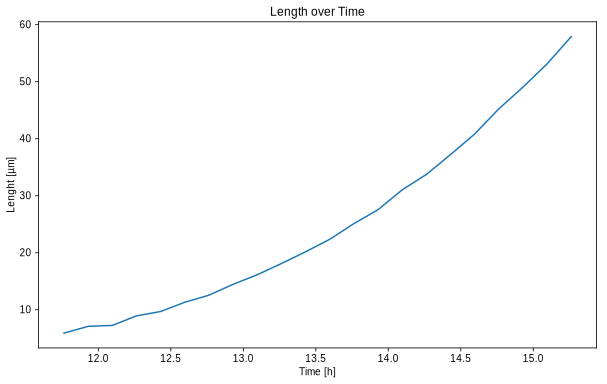

In [13]:
timepoint = the_longest_track.timepoint / (60*60)
length = the_longest_track.distance

pyplot.title('Length over Time')

pyplot.xlabel('Time [h]')
pyplot.ylabel('Lenght [µm]')

pyplot.plot(timepoint, length)

Now all tracked hyphae:

(0, 22.961576228743152)

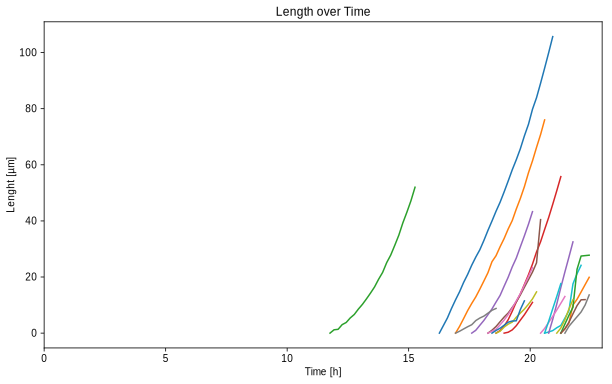

In [14]:
pyplot.title('Length over Time')

pyplot.xlabel('Time [h]')
pyplot.ylabel('Lenght [µm]')

for idx, row in track_table.iterrows():
    particular_tracking_table = int(row.aux_table)  
    index = _mapping_track_table_aux_tables.query('_index == @particular_tracking_table').individual_table
    track = store[getattr(position.tables._individual_track_table_aux_tables, 'track_table_aux_tables_%09d' % (index,))._v_pathname]
    
    timepoint = track.timepoint / (60*60)
    length = track.distance - track.distance.min()
    pyplot.plot(timepoint, length)
    
pyplot.xlim(0, None)